# Is the lateralization effect stronger at 7T than in the PET?

Many of these patients have either hippocampal or temporal PET qualitative asymmetries. Is the difference between left and right TLE largest at 7T or with what is currently being used clinically, which is PET?

Import the functions

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import os
from scipy import stats
import matplotlib.pyplot as plt

colors = ["#FF5733","#1F77B4"]
sns.set_palette(colors)

# Plotting Parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE, family='Arial')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.nanvar(d1, ddof=1), np.nanvar(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.nanmean(d1), np.nanmean(d2)
	# calculate the effect size
	return (u1 - u2) / s

Load data generated by `voxelwise_analysis.ipynb`

In [2]:
df_seed_all = pd.read_pickle('df_seed_all_2_27_23.pkl')

## Register and Process the PET in the Native T1 Space

Sandy suggested that the PET be registered to the T1 space and analyzed either there or then in MNI space. Since I have the DKT segmentation for each patient in native space, I will use that

In [14]:
# Load the dataframe with the paired subjects
subjects = df_seed_all['Record ID']

source_pet = '/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS'

for sub in subjects:
    matrix_fname = os.path.join(source_pet,sub+'_pet_to_t1.mat')
    pet_fname = os.path.join(source_pet,sub+'_ses-clinical01_pet.nii.gz')
    t1_fname = os.path.join(source_pet,sub+'_ses-research3Tv*_acq-3D_T1w.nii.gz')
    seg_fname = os.path.join(source_pet,sub+'_aparc.DKTatlas+aseg.nii.gz')
    out_fname = os.path.join(source_pet,sub+'_ses-clinical01_space-T1w_pet.nii.gz')

    # reslice to the segmentation since there might be slight discrepancies in size
    !c3d $seg_fname $pet_fname -reslice-matrix $matrix_fname -o $out_fname


Exception caught of type 16ConvertException
  Exception detail: Unable to read matrix /Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS/sub-RID0646_pet_to_t1.mat
Exception caught of type 16ConvertException
  Exception detail: Unable to read image /Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS/sub-RID0119_aparc.DKTatlas+aseg.nii.gz; IO factory can not create IO object.
Exception caught of type 16ConvertException
  Exception detail: Unable to read image /Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS/sub-RID0029_aparc.DKTatlas+aseg.nii.gz; IO factory can not create IO object.
Exception caught of type 16ConvertException
  Exception detail: Unable to read image /Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS/sub-RID0143_aparc.DKTatlas+aseg.nii.gz; IO factory can not create IO object.


### Quantifying the PET Asymmetry in the DKT atlas

Creating temporal and mesial temporal masks for the PET quantification

In [3]:
def nan_zero_set_zero(img):
    img = (img>0).astype(float)
    img[img==0] = np.nan
    return img

In [5]:
# region values for the DKT atlas

def get_regions_dkt(native_dkt_atlas):
    right_temporal = nan_zero_set_zero((native_dkt_atlas==2030) + (native_dkt_atlas==2015) + (native_dkt_atlas==2009))
    left_temporal = nan_zero_set_zero((native_dkt_atlas==1030) + (native_dkt_atlas==1015) + (native_dkt_atlas==1009))

    right_mtl = nan_zero_set_zero((native_dkt_atlas==2016) + (native_dkt_atlas==2006) + (native_dkt_atlas==54) + (native_dkt_atlas==53))
    left_mtl = nan_zero_set_zero((native_dkt_atlas==1016) + (native_dkt_atlas==1006) + (native_dkt_atlas==18) + (native_dkt_atlas==17))

    right_sma = nan_zero_set_zero((native_dkt_atlas==2003))
    left_sma = nan_zero_set_zero((native_dkt_atlas==1003))


    return right_temporal , left_temporal, right_mtl, left_mtl, right_sma, left_sma


In [6]:
source_pet = '/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS'

subjects = df_seed_all['Record ID']

left_temporal_list = []
right_temporal_list = []
left_mtl_list = []
right_mtl_list = []
left_sma_list = []
right_sma_list = []


subjects_pet = []

for i in subjects:
    pet_path = os.path.join(source_pet,i+'_ses-clinical01_space-T1w_pet.nii.gz')
    seg_path = os.path.join(source_pet,i+'_aparc.DKTatlas+aseg.nii.gz')
    #print(pet_path)
    if os.path.exists(pet_path):
        print(pet_path)

        right_temporal , left_temporal, right_mtl, left_mtl, right_sma, left_sma = get_regions_dkt(nib.load(seg_path).get_fdata())

        pet = nib.load(pet_path).get_fdata()
        left_temporal_list.append(np.nanmean(pet*left_temporal))
        right_temporal_list.append(np.nanmean(pet*right_temporal))

        left_mtl_list.append(np.nanmean(pet*left_mtl))
        right_mtl_list.append(np.nanmean(pet*right_mtl))
        
        left_sma_list.append(np.nanmean(pet*left_sma))
        right_sma_list.append(np.nanmean(pet*right_sma))
        

        subjects_pet.append(i)
    else:
        print(i,' does not exist')

/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS/sub-RID0420_ses-clinical01_space-T1w_pet.nii.gz
/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS/sub-RID0365_ses-clinical01_space-T1w_pet.nii.gz
/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS/sub-RID0448_ses-clinical01_space-T1w_pet.nii.gz
/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS/sub-RID0121_ses-clinical01_space-T1w_pet.nii.gz
/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS/sub-RID0455_ses-clinical01_space-T1w_pet.nii.gz
/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS/sub-RID0490_ses-clinical01_space-T1w_pet.nii.gz
/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/source_data/PET_analysis/missing_pets/BIDS/sub-RID0508_ses-clinical01_space-T1w_pet.nii.gz
/Volumes/T7_Shield/research/CNT/P18_7T_rs

In [7]:
df_pet = pd.DataFrame()

df_pet['Record ID'] = subjects_pet
df_pet['Left Temporal'] = left_temporal_list
df_pet['Right Temporal'] = left_temporal_list

df_pet['Left MTL'] = left_temporal_list
df_pet['Right MTL'] = left_temporal_list

df_pet['AI Temporal'] = (np.array(right_temporal_list)-np.array(left_temporal_list))/(np.array(left_temporal_list)+np.array(right_temporal_list))
df_pet['AI MTL'] = (np.array(right_mtl_list)-np.array(left_mtl_list))/(np.array(left_mtl_list)+np.array(right_mtl_list))
df_pet['AI SMA'] = (np.array(right_sma_list)-np.array(left_sma_list))/(np.array(left_sma_list)+np.array(right_sma_list))

In [8]:
df_pet_fmri = pd.merge(df_pet, df_seed_all, on='Record ID')

df_pet_fmri = df_pet_fmri[(df_pet_fmri['Lateralization']=='Left') | (df_pet_fmri['Lateralization']=='Right')]

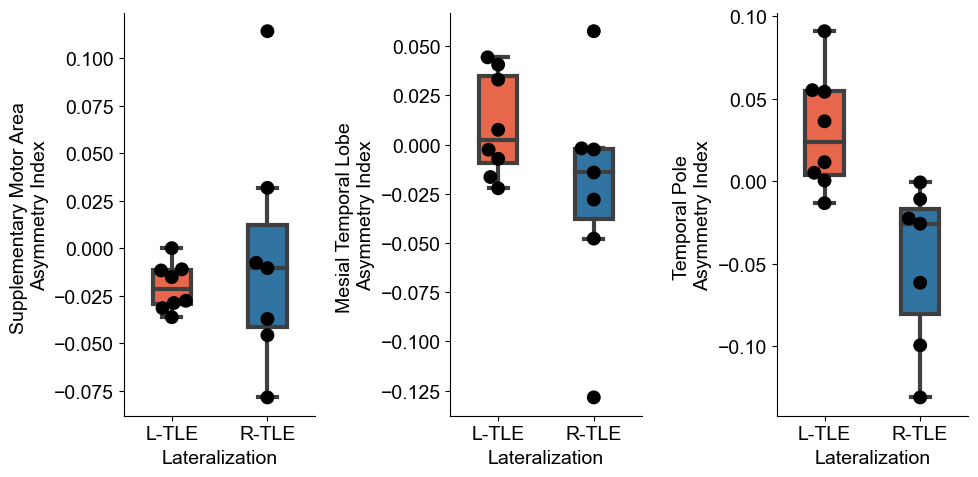

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(133)
sns.boxplot(x='Lateralization', y='AI Temporal', data=df_pet_fmri, linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='AI Temporal', data=df_pet_fmri,  size=10, color='k')
plt.ylabel('Temporal Pole \nAsymmetry Index')
plt.xticks([0,1],['L-TLE','R-TLE'])
plt.subplot(132)

sns.boxplot(x='Lateralization', y='AI MTL', data=df_pet_fmri, linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='AI MTL', data=df_pet_fmri,  size=10, color='k')
plt.ylabel('Mesial Temporal Lobe \nAsymmetry Index')

plt.tight_layout()
sns.despine()
plt.xticks([0,1],['L-TLE','R-TLE'])

plt.subplot(131)

sns.boxplot(x='Lateralization', y='AI SMA', data=df_pet_fmri, linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='AI SMA', data=df_pet_fmri,  size=10, color='k')
plt.ylabel('Supplementary Motor Area \nAsymmetry Index')

sns.despine()
plt.xticks([0,1],['L-TLE','R-TLE'])
plt.tight_layout()

#plt.savefig('/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/output/figures/figures_2023/pet_asymmetry.pdf')
#plt.savefig('/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/output/figures/figures_2023/pet_asymmetry_updated.pdf')


In [10]:
print('Temporal PET t-test: ',stats.ttest_ind(df_pet_fmri[df_pet_fmri['Lateralization']=='Left']['AI Temporal'],df_pet_fmri[df_pet_fmri['Lateralization']=='Right']['AI Temporal']))
print('Temporal PET Cohen d: ',cohend(df_pet_fmri[df_pet_fmri['Lateralization']=='Left']['AI Temporal'],df_pet_fmri[df_pet_fmri['Lateralization']=='Right']['AI Temporal']))

print('MTL PET t-test: ',stats.ttest_ind(df_pet_fmri[df_pet_fmri['Lateralization']=='Left']['AI MTL'],df_pet_fmri[df_pet_fmri['Lateralization']=='Right']['AI MTL']))
print('MTL PET Cohen d: ',cohend(df_pet_fmri[df_pet_fmri['Lateralization']=='Left']['AI MTL'],df_pet_fmri[df_pet_fmri['Lateralization']=='Right']['AI MTL']))

Temporal PET t-test:  Ttest_indResult(statistic=3.6797597980811667, pvalue=0.0027751279196475075)
Temporal PET Cohen d:  1.9044566274812913
MTL PET t-test:  Ttest_indResult(statistic=1.4917851068413865, pvalue=0.15961957373952526)
MTL PET Cohen d:  0.7720721431283213


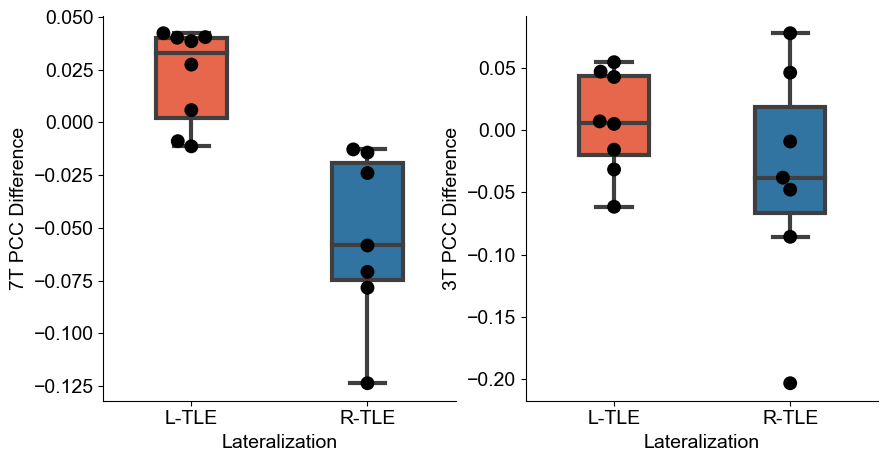

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.boxplot(x='Lateralization', y='7T PCC Difference', data=df_pet_fmri, linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='7T PCC Difference', data=df_pet_fmri,  size=10, color='k')
plt.xticks([0,1],['L-TLE','R-TLE'])
sns.despine()

plt.subplot(122)
sns.boxplot(x='Lateralization', y='3T PCC Difference', data=df_pet_fmri, linewidth=3, width=0.4)
sns.swarmplot(x='Lateralization', y='3T PCC Difference', data=df_pet_fmri,  size=10, color='k')
plt.xticks([0,1],['L-TLE','R-TLE'])
sns.despine()

#plt.savefig('/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/output/figures/figures_2023/pcc_difference_pet.pdf')

In [14]:
stats.ttest_ind(df_pet_fmri[df_pet_fmri['Lateralization']=='Left']['7T PCC Difference'],df_pet_fmri[df_pet_fmri['Lateralization']=='Right']['7T PCC Difference'])

Ttest_indResult(statistic=4.560136441469085, pvalue=0.0005351588829511285)

In [15]:
cohend(df_pet_fmri[df_pet_fmri['Lateralization']=='Left']['7T PCC Difference'],df_pet_fmri[df_pet_fmri['Lateralization']=='Right']['7T PCC Difference'])

2.3600948281198626

In [16]:
stats.ttest_ind(df_pet_fmri[df_pet_fmri['Lateralization']=='Left']['3T PCC Difference'],df_pet_fmri[df_pet_fmri['Lateralization']=='Right']['3T PCC Difference'])

Ttest_indResult(statistic=1.197203562498268, pvalue=0.25260265169364393)

Spearman correlation:  SignificanceResult(statistic=0.6428571428571428, pvalue=0.009739944695595262)
Spearman correlation:  SignificanceResult(statistic=0.11071428571428568, pvalue=0.6944626472070963)


<Figure size 300x300 with 0 Axes>

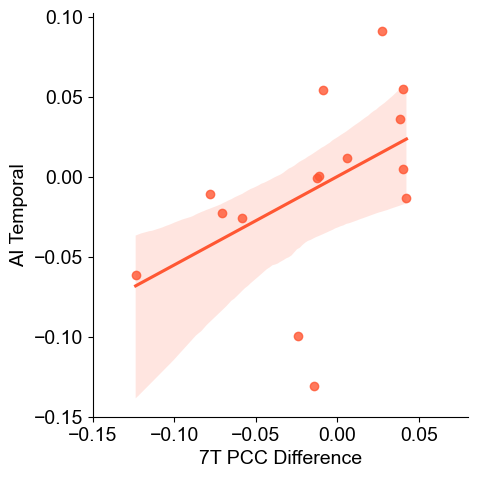

<Figure size 640x480 with 0 Axes>

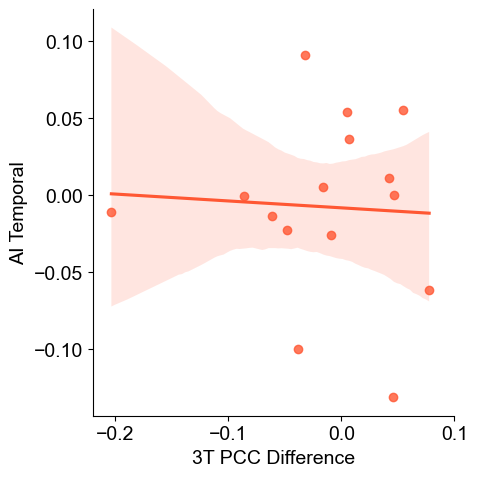

In [17]:
plt.figure(figsize=(3,3))
sns.lmplot(x='7T PCC Difference', y='AI Temporal', data=df_pet_fmri)
print('Spearman correlation: ', stats.spearmanr(df_pet_fmri['7T PCC Difference'], df_pet_fmri['AI Temporal']))

plt.xlim([-0.15,0.08])
plt.tight_layout()
plt.savefig('/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/output/figures/figures_2023/corr_7t_pet.pdf')

plt.figure()
sns.lmplot(x='3T PCC Difference', y='AI Temporal', data=df_pet_fmri)
print('Spearman correlation: ', stats.spearmanr(df_pet_fmri['3T PCC Difference'], df_pet_fmri['AI Temporal']))
plt.xlim([-0.22,0.10])
plt.tight_layout()
#plt.savefig('/Volumes/T7_Shield/research/CNT/P18_7T_rsfMRI/output/figures/figures_2023/corr_3t_pet.pdf')


Spearman correlation:  SignificanceResult(statistic=-0.16785714285714282, pvalue=0.5498555542278019)
Spearman correlation:  SignificanceResult(statistic=-0.125, pvalue=0.6571356681869504)


(-0.15, 0.08)

<Figure size 640x480 with 0 Axes>

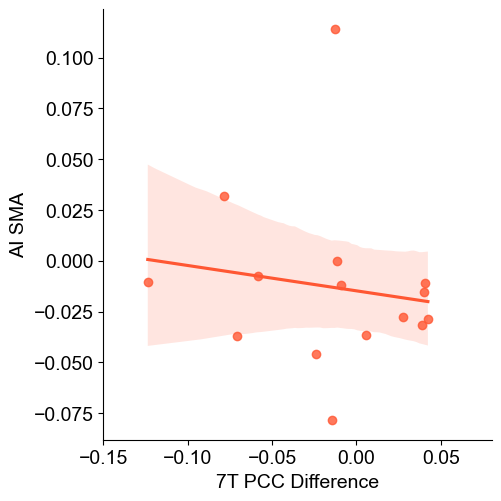

<Figure size 640x480 with 0 Axes>

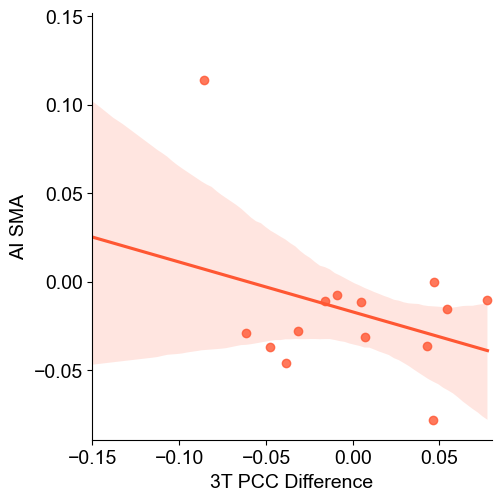

In [13]:
plt.figure()
sns.lmplot(x='7T PCC Difference', y='AI SMA', data=df_pet_fmri)
print('Spearman correlation: ', stats.spearmanr(df_pet_fmri['7T PCC Difference'], df_pet_fmri['AI SMA']))
plt.xlim([-0.15,0.08])

plt.figure()
sns.lmplot(x='3T PCC Difference', y='AI SMA', data=df_pet_fmri)
print('Spearman correlation: ', stats.spearmanr(df_pet_fmri['3T PCC Difference'], df_pet_fmri['AI SMA']))
plt.xlim([-0.15,0.08])